In [1]:
import traitlets
from ipywidgets import widgets
from IPython.display import display
from tkinter import Tk, filedialog
import re

class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        with out:
            try:
                # Create Tk root
                root = Tk()
                # Hide the main window
                root.withdraw()
                # Raise the root to the top of all windows.
                root.call('wm', 'attributes', '.', '-topmost', True)
                # List of selected fileswill be set to b.value
                b.files = filedialog.askopenfilename(multiple=True)

                b.description = "Files Selected"
                b.icon = "check-square-o"
                b.style.button_color = "lightgreen"
            except:
                pass


In [2]:
import segyio, pandas as pd
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header


In [6]:
out = widgets.Output()
raw = SelectFilesButton()
widgets.VBox([raw, out])

In [15]:
print(raw.files[0])



/home/bt/mnt/crush-data/geophys/interp/barrel_award/2019/Scarborough NW Australia_petrel_barrel2019/JA95/ja95-ja95-103_Amplitudes.sgy


In [16]:
import re

with segyio.open(raw.files[0], ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 14605, N Samples: 1751, Sample rate: 4.0ms'

In [17]:
text_headers

{'C01': '1 CLIENT                        COMPANY                       CREW NO         ',
 'C02': '2 LINE JA95-JA95-103_AMPLITUDES               MAP ID ',
 'C03': '3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER ',
 'C04': '4 SHOTPOINT:    5       LONG       SHOTPOINT FOR 2D AND 3D SURVEY DATA ',
 'C05': '5 LINE NUMBER:  17       LONG       LINE RECORD ',
 'C06': '6 TRACE NUMBER: 25       LONG       TRACE RECORD(CDP Number) ',
 'C07': '7 SHOTPOINT:   21       LONG       SHOTPOINT FOR ARBITRARY LINE ',
 'C08': '8 CDP_X:        73       LONG       CDPBIN NUMBER ',
 'C09': '9 CDP_Y:        77       LONG       CDPBIN NUMBER C10 NSAMPLE:      115 UNSIGNED SHORT  NUMBER OF SAMPLES C11 SRATE:        117 UNSIGNED SHORT  SAMPLE RATE C12 C13 C14 C15 C16 C17 C18 C19 C20 C21 C22 C23 C24 C25 C26 C27 C28 C29 C30 C31 C32 C33 C34 C35 C36 C37 C38 C39 C40 END EBCDIC '}

In [18]:
import numpy as np
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'


'The 99th percentile is 4; the max amplitude is 34'

Text(0.5, 1.0, '/home/bt/mnt/crush-data/geophys/interp/barrel_award/2019/Scarborough NW Australia_petrel_barrel2019/JA95/ja95-ja95-103_Amplitudes.sgy')

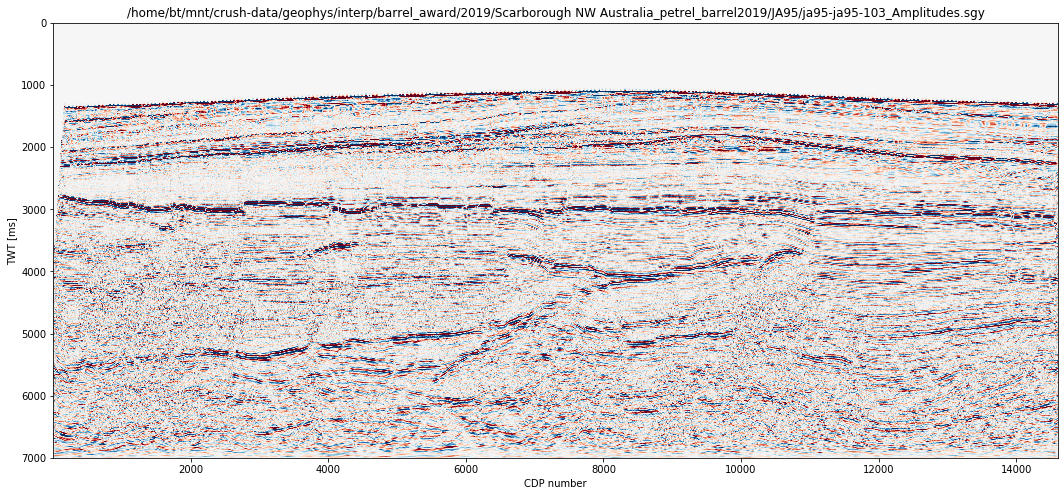

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'{raw.files[0]}')
